In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from pycolleff.longitudinal_equilibrium import ImpedanceSource, LongitudinalEquilibrium
import pycolleff.rings.sirius as sirius
import pycolleff.impedances as imp

# mplt.style.use('science')
plt.rcParams.update({
    'font.size': 18, 'axes.grid': True,
    'grid.linestyle': '--', 'grid.alpha': 0.5})

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.top'] = False

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from scipy.constants import speed_of_light as c

In [76]:
def create_equi(ring, impedances, feedback=False):
    fill = np.ones(ring.harm_num)/ring.harm_num
    equi = LongitudinalEquilibrium(ring=ring, impedance_sources=impedances, fillpattern=fill)
    equi.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb/2
    equi.feedback_on = feedback
    equi.identical_bunches = True
    return equi

def scan_hc_voltage(voltages, equi, cbmode, mmax, nr_equi_iters=20):
    ad_rates = []
    cf_rates = []
    mc_rates = []
    oy_rates = []
    ich_freq = []
    min_freq = []
    max_freq = []
    
    print("HC voltage (kV)  HC detune (kHz)")

    for voltage in voltages:
        for _ in range(nr_equi_iters):
            detune_angle = equi.calc_detune_for_fixed_harmonic_voltage(
                peak_harm_volt=voltage, Rs=equi.impedance_sources[-1].shunt_impedance)
            equi.impedance_sources[-1].detune_angle = detune_angle
            dists = equi.calc_longitudinal_equilibrium(niter=10000, beta=0.1, tol=1e-8, m=3, print_flag=False)
            
        print(f"{voltage/1e3:15.2f} {equi.impedance_sources[-1].detune_freq/1e3:15.2f}")

        equi.calc_equilibrium_info(nrpts=51)
        _ = equi.calc_canonical_transformation()

        zij = equi.equilibrium_info["canonical_zj"]
        min_freq.append(equi.equilibrium_info["sync_freq"].min())
        max_freq.append(equi.equilibrium_info["sync_freq"].max())
        
        ms = np.arange(1, mmax+1)
        ps = np.array([-3, 3])
        w0 = equi.ring.rev_ang_freq
        h = equi.ring.harm_num
        hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)

        z0, sigmaz = equi.calc_moments(equi.zgrid, equi.distributions)
        sigmaz = sigmaz[0]

        # Calculate the equivalent synchrotron frequency:
        # Equivalent single-rf (quadratic) potential.
        #     Sync. frequency determined by bunch length
        sync_freq = equi.ring.espread * equi.ring.mom_comp * c
        sync_freq /= sigmaz * 2 * np.pi
        #     print(f"FREQ BY BUNCH LENGTH: {sync_freq:.5f} Hz")

#         if voltage < 250e3:
#             x0 = [500*2*np.pi, equi.ring.dampte]
#         else:  
#             x0 = [0.1*2*np.pi, equi.ring.dampte]
        
#         x0 = [10*2*np.pi, equi.ring.dampte]
        x0 = [2*np.pi* sync_freq, equi.ring.dampte]
#         x0 = [2*np.pi* 2 * sync_freq, equi.ring.dampte]

        coherent_freq, growth_rate = equi.solve_lebedev(x0, hmps, ms, ps, cbmode, method='lm', reduced=True)
        ad_rates.append(coherent_freq + 1j * growth_rate)

        ms = np.sort(np.r_[-np.arange(1, mmax+1), np.arange(1, mmax+1)])
        hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)
        eigvals, eigvecs = equi.solve_lebedev_constant_frequency(hmps, ms, ps, cbmode, effsyncfreq='bunchlength')
        cf_rates.append(eigvals)
        ich_freq.append(sync_freq)

        equi.ring.sync_tune = sync_freq / equi.ring.rev_freq
        equi.ring.bunlen = sigmaz

        # Calculate Vlasov's equation eigen-frequencies:
        wrf = equi.ring.rf_ang_freq
        eigenfreq, *_ = equi.calc_mode_coupling(
            w=[-10 * wrf, +10 * wrf],
            cbmode=cbmode,
            max_azi=mmax,
            max_rad=1,
            use_fokker=False,
            delete_m0=True,
            delete_m0k0=True,
            reduced=True,
        )
        mc_rates.append(eigenfreq)

        #     eigvals, _ = equi.solve_oide_yokoya(hmps, ms, ps, cbmode)
        #     oy_rates.append(eigvals)

    ad_rates = np.array(ad_rates)
    cf_rates = np.array(cf_rates)
    mc_rates = np.array(mc_rates)
    ich_freq = np.array(ich_freq)
    min_freq = np.array(min_freq)
    max_freq = np.array(max_freq)
    # oy_rates = np.array(oy_rates)
    return ad_rates, cf_rates, mc_rates, ich_freq, min_freq, max_freq


def plot_scan_hc_voltage(
    voltages, fp_voltage,
    ad_rates, cf_rates, mc_rates, ich_freq, 
    xticks=None, yticks=None, xlim=None, ylim=None, filename=None):
    
    fig = plt.figure(figsize=(8, 6))
    scale = 1
    plt.plot(voltages/1e3, np.abs(ad_rates.real)*scale, 'o', ms=9, color='tab:gray', label=r'Re($\Omega$) Lebedev', alpha=0.5)
    plt.plot(voltages/1e3, np.abs(cf_rates.real)/2/np.pi*scale, 'x', color='g', label=r'Re($\Omega$) Effective ${\omega_s}(\sigma_z)$')
    plt.plot(voltages/1e3, np.abs(mc_rates.real)/2/np.pi*scale, '.', color='tab:orange', label=r'Re($\Omega$) Gaussian LMCI')
    plt.plot(voltages/1e3, np.array(ich_freq)*scale, color="k", label=r"Incoherent $m{\omega_s}(\sigma_z)$")
    plt.plot(voltages/1e3, 2*np.array(ich_freq)*scale, color="k")
    
    # plt.plot(voltages/1e3, np.array(min_freq)*scale, color="k", ls='--')
    # plt.plot(voltages/1e3, np.array(max_freq)*scale, color="k", ls='--')
    
    plt.axvline(fp_voltage/1e3, ls='--', color='tab:gray', lw=2)
    
    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
#     plt.xticks(np.arange(70, 200, 10))
#     plt.yticks(np.arange(0, 4500, 500))
#     plt.xlim(left=fp_voltage*0.5/1e3, right=fp_voltage*1.03/1e3)

    plt.grid(True, ls='--', alpha=0.25)
    plt.xlabel("harmonic voltage (kV)")
    plt.ylabel("frequency (Hz)")

    dampte = equi.ring.dampte
    limit = 1/dampte
    grows = np.abs(ad_rates.imag)
    
    def my_criteria(grow):
        return grow > limit
    first_true = next((i for i, g in enumerate(grows) if my_criteria(g)), None)
    if first_true is not None:
        instability_limit = voltages[first_true]/1e3
        print("HC voltage threshold (kV)")
        print(instability_limit)
        color = 'tab:red'
        plt.axvline(instability_limit, 0, 1, color=color, linestyle=":", alpha=0.5, lw=2)
        plt.axvspan(instability_limit, voltages.max()/1e3, color=color, alpha=0.1, label=r"Unstable Im($\Omega$) $> 1/\tau_\delta$")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(
        by_label.values(), 
        by_label.keys(), 
        fontsize="x-small", ncol=2, loc='upper right')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
def plot_scan_hc_voltage_growth(
    voltages, fp_voltage,
    ad_rates, cf_rates, mc_rates, ich_freq, 
    xticks=None, yticks=None, xlim=None, ylim=None, filename=None):
    
    fig = plt.figure(figsize=(8, 6))
    scale = 1
    plt.plot(voltages/1e3, (ad_rates.imag), 'o', ms=9, color='tab:gray', label=r'Re($\Omega$) Lebedev', alpha=0.5)
    plt.plot(voltages/1e3, (cf_rates.imag), 'x', color='g', label=r'Re($\Omega$) Effective ${\omega_s}(\sigma_z)$')
    plt.plot(voltages/1e3, (mc_rates.imag), '.', color='tab:orange', label=r'Re($\Omega$) Gaussian LMCI')
    
    # plt.plot(voltages/1e3, np.array(min_freq)*scale, color="k", ls='--')
    # plt.plot(voltages/1e3, np.array(max_freq)*scale, color="k", ls='--')
    
    plt.axvline(fp_voltage/1e3, ls='--', color='tab:gray', lw=2)
    
    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
#     plt.xticks(np.arange(70, 200, 10))
#     plt.yticks(np.arange(0, 4500, 500))
#     plt.xlim(left=fp_voltage*0.5/1e3, right=fp_voltage*1.03/1e3)

    plt.grid(True, ls='--', alpha=0.25)
    plt.xlabel("harmonic voltage (kV)")
    plt.ylabel("growth rate (1/s)")

    dampte = equi.ring.dampte
    limit = 1/dampte
#     plt.axhline(limit, color='r', ls='--')
    grows = np.abs(ad_rates.imag)
    
    def my_criteria(grow):
        return grow > limit
    first_true = next((i for i, g in enumerate(grows) if my_criteria(g)), None)
    if first_true is not None:
        instability_limit = voltages[first_true]/1e3
        print("HC voltage threshold (kV)")
        print(instability_limit)
        color = 'tab:red'
        plt.axvline(instability_limit, 0, 1, color=color, linestyle=":", alpha=0.5, lw=2)
        plt.axvspan(instability_limit, voltages.max()/1e3, color=color, alpha=0.1, label=r"Unstable Im($\Omega$) $> 1/\tau_\delta$")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(
        by_label.values(), 
        by_label.keys(), 
        fontsize="x-small", ncol=2, loc='upper right')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
def scan_current_keep_fp(
    currents, ring, impedances, cbmode, mmax, nr_equi_iters=20, method='lebedev'):
    rates = []
    ich_freq = []
    
    print("HC voltage (kV)  HC detune (kHz)")
    
    threshold_current = None
    for current in currents:
        print(f"Current: {current*1e3:.2f} mA")
        
        ring.total_current = current
        equi = create_equi(ring, impedances)
        
        peak_harm_volt = equi.calc_harmonic_voltage_for_flat_potential()
        peak_harm_volt *= equi.ring.gap_voltage 
        detune_angle = equi.calc_detune_for_fixed_harmonic_voltage(
            peak_harm_volt=peak_harm_volt, Rs=impedances[-1].shunt_impedance)

        for _ in range(nr_equi_iters):
            detune_angle = equi.calc_detune_for_fixed_harmonic_voltage(
                peak_harm_volt=peak_harm_volt, Rs=equi.impedance_sources[-1].shunt_impedance)
            equi.impedance_sources[-1].detune_angle = detune_angle
            dists = equi.calc_longitudinal_equilibrium(niter=10000, beta=0.1, tol=1e-8, m=3, print_flag=False)
            
#         print(f"{peak_harm_volt/1e3:15.2f} {equi.impedance_sources[-1].detune_freq/1e3:15.2f}")
        
        z0, sigmaz = equi.calc_moments(equi.zgrid, equi.distributions)
        sigmaz = sigmaz[0]
#         sync_freq = (0.8039/2) * equi.ring.espread * equi.ring.mom_comp * c
        sync_freq = equi.ring.espread * equi.ring.mom_comp * c
        sync_freq /= sigmaz * 2 * np.pi
        
        ich_freq.append(sync_freq)
        
        
        if method in ['lebedev', 'effective']:
            equi.calc_equilibrium_info(nrpts=51)
            #     equi.calc_synchrotron_frequency(nrpts=51)
            #     zij, *_ = equi.calc_canonical_transformation()
            _ = equi.calc_canonical_transformation()

            zij = equi.equilibrium_info["canonical_zj"]
#             min_freq.append(equi.equilibrium_info["sync_freq"].min())
#             max_freq.append(equi.equilibrium_info["sync_freq"].max())

            ms = np.arange(1, mmax+1)
            ps = np.array([-3, 3])
            w0 = equi.ring.rev_ang_freq
            h = equi.ring.harm_num
            hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)
            
            if method == 'lebedev':
                x0 = [10 * 2 * np.pi, 1/equi.ring.dampte]
                coherent_freq, growth_rate = equi.solve_lebedev(
                    x0, hmps, ms, ps, cbmode, method='lm', reduced=True)
                rates.append(coherent_freq + 1j * growth_rate)
            elif method == 'effective':
                ms = np.sort(np.r_[-np.arange(1, mmax+1), np.arange(1, mmax+1)])
                hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)
                eigvals, eigvecs = equi.solve_lebedev_constant_frequency(
                    hmps, ms, ps, cbmode, effsyncfreq='bunchlength')
                rates.append(eigvals)
        elif method == 'lmci':
            equi.ring.sync_tune = sync_freq / equi.ring.rev_freq
            equi.ring.bunlen = sigmaz

            # Calculate Vlasov's equation eigen-frequencies:
            wrf = equi.ring.rf_ang_freq
            eigenfreq, *_ = equi.calc_mode_coupling(
                w=[-10 * wrf, +10 * wrf],
                cbmode=cbmode,
                max_azi=mmax,
                max_rad=1,
                use_fokker=False,
                delete_m0=True,
                delete_m0k0=True,
                reduced=True,
            )
            rates.append(eigenfreq)
        
        print(f'Growth rate {np.max(rates[-1].imag):.4f}, Damping rate {1/equi.ring.dampte:.2f}')
        if np.max(rates[-1].imag) > 1/equi.ring.dampte:
            threshold_current = current
            break

    rates = np.array(rates)
    ich_freq = np.array(ich_freq)
    return rates, ich_freq, threshold_current

In [35]:
ring = sirius.create_ring()
ring.en_lost_rad = 670e3
ring.gap_voltage = 2.5e6
ring.total_current = 350e-3
print(ring)

Lattice Version             :   SI.v25.01-s05.02  
Circumference [m]           :       518.387       
Revolution Period [us]      :        1.729        
Revolution Frequency [kHz]  :       578.318       
Energy [GeV]                :        3.000        
U0 [keV]                    :       670.000       
Vgap [MV]                   :        2.500        
Momentum Compaction         :       1.63e-04      
Harmonic Number             :         864         
Current [mA]                :       350.000       
Current per Bunch [mA]      :        0.405        
Synchrotron Tune            :       0.00356       
Tunes x/y                   :    49.078/14.137    
Chromaticities x/y          :     2.500/2.500     
Damping Times x/y/e [ms]    :   16.9/ 22.0 /12.9  
Energy Spread [%]           :        0.0887       
Bunch Length [mm]           :        3.250        



In [36]:
hcav = ImpedanceSource()
hcav.harm_rf = 3
hcav.Q = 2e8
RoverQ = 87.5 
hcav.shunt_impedance = RoverQ * hcav.Q
twopi = 2 * np.pi
hcav.ang_freq_rf = twopi * ring.rf_freq
hcav.ang_freq = hcav.harm_rf * hcav.ang_freq_rf
hcav.detune_w = twopi * 60e3
hcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
hcav.active_passive = ImpedanceSource.ActivePassive.Passive
print(hcav)

calc_method         : ImpedanceDFT  
active_passive      : Passive  
ang_freq_rf         : 3139.50  [Mrad/s]
ang_freq            : 9418.87  [Mrad/s]
shunt_impedance     : 17500.00  [MOhm]
Q                   : 2.00e+08  
RoverQ              : 87.50  [Ohm]
harm_rf             : 3.00  
detune_angle        : 1.57  [rad]
detune_freq         : 60.00  [kHz]
detune_w            : 376991.12  [rad/s]
alpha               : 23.55  [rad/s]
ang_freq_bar        : 9418.87  [Mrad/s]



In [37]:
equi = create_equi(ring, [hcav, ])

In [38]:
nr_equi_iters = 50
kharm = equi.calc_harmonic_voltage_for_flat_potential()
vharm = kharm * equi.ring.gap_voltage
for _ in range(nr_equi_iters):
    angle = equi.calc_detune_for_fixed_harmonic_voltage(
        vharm, 
        Rs=equi.impedance_sources[-1].shunt_impedance)
    equi.impedance_sources[-1].detune_angle = angle
    equi.calc_longitudinal_equilibrium(niter=10000, beta=0.1, tol=1e-8, m=3, print_flag=False)

In [39]:
hcav = equi.impedance_sources[-1]
hvolt = equi.calc_induced_voltage_wake(
    dist=equi.distributions, wake_source=hcav)
mvolt = equi.main_voltage
tvolt = mvolt + hvolt
peak_hvolt = np.max(np.abs(hvolt[0, :]))
peak_mvolt = np.max(np.abs(mvolt))

fp_voltage = peak_hvolt

print(f'current: {equi.ring.total_current*1e3:.2f} mA')
print(f'detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz')
print(f'detune angle: {np.rad2deg(hcav.detune_angle):.3f} deg')
print(f'R/Q: {hcav.shunt_impedance/hcav.Q:.1f} Ohm')
print(f'HC voltage: {peak_hvolt/1e3:.2f} kV')
ratio = peak_hvolt/peak_mvolt
print(f'HC voltage ratio: {ratio:.4f}')

current: 350.00 mA
detune: 53.176 kHz
detune angle: 89.996 deg
R/Q: 87.5 Ohm
HC voltage: 798.97 kV
HC voltage ratio: 0.3196


In [40]:
nr_equi_iters = 50
harmonic_voltage = peak_hvolt
# harmonic_voltage = 700e3
for _ in range(nr_equi_iters):
    detune_angle = equi.calc_detune_for_fixed_harmonic_voltage(
        peak_harm_volt=harmonic_voltage, Rs=equi.impedance_sources[-1].shunt_impedance)
    equi.impedance_sources[-1].detune_angle = detune_angle
    equi.calc_longitudinal_equilibrium(niter=10000, beta=0.1, tol=1e-8, m=3, print_flag=False)

In [41]:
# print(equi.equilibrium_info.keys())
equi.calc_equilibrium_info(nrpts=51)  # compute action-dependent quantities
print(equi.equilibrium_info.keys())

dict_keys(['sync_freq', 'avg_sync_freq', 'std_sync_freq', 'action_distribution', 'action', 'hamiltonian', 'amplitude', 'zmin', 'total_voltage', 'total_potential', 'zgrid', 'zdistribution'])


<IPython.core.display.Javascript object>


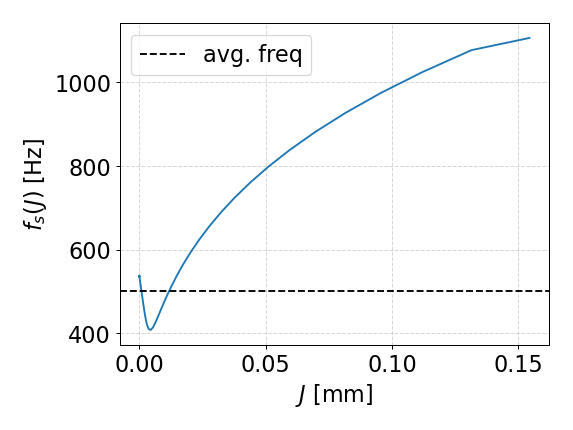

In [42]:
plt.figure()
plt.plot(
    equi.equilibrium_info['action']*1e3, 
    equi.equilibrium_info['sync_freq'])
plt.axhline(
    equi.equilibrium_info['avg_sync_freq'], label='avg. freq',
    color='k', ls='--')
plt.xlabel(r'$J$ [mm]')
plt.ylabel(r'$f_s(J)$ [Hz]')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


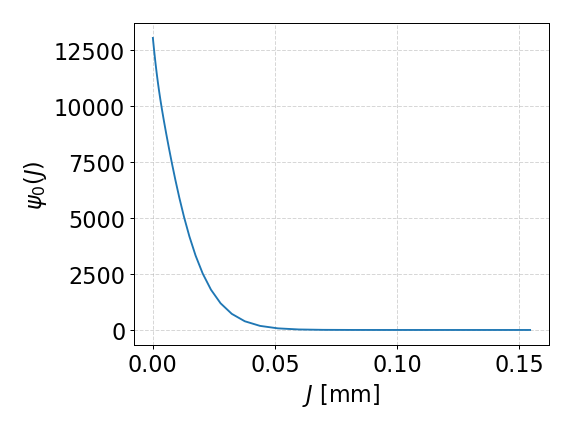

In [43]:
plt.figure()
plt.plot(
    equi.equilibrium_info['action']*1e3, 
    equi.equilibrium_info['action_distribution'])
plt.xlabel(r'$J$ [mm]')
plt.ylabel(r'$\psi_0(J)$')
plt.tight_layout()
plt.show()

In [44]:
_ = equi.calc_canonical_transformation()  # z = z(J_i, phi_j)
zij = equi.equilibrium_info["canonical_zj"]
dij = equi.equilibrium_info["canonical_deltaj"]

In [45]:
print(len(zij))

# each action index has a different number of angle data
print(len(zij[0]), len(zij[1]), len(zij[2]))

51
10603 10608 10616


<IPython.core.display.Javascript object>


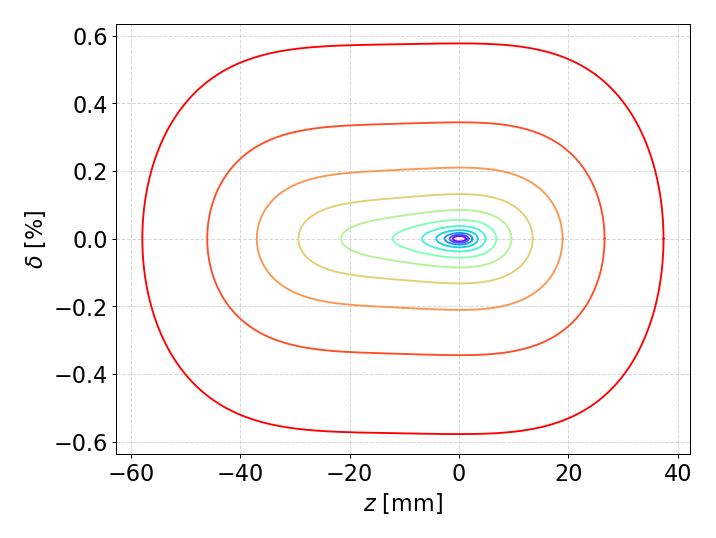

In [46]:
idcs = np.arange(0, 51, 5)

# Normalize the indices to map to the colormap range [0, 1]
norm = mcolors.Normalize(vmin=min(idcs), vmax=max(idcs))
cmap = cm.rainbow  # You can choose other colormaps like 'plasma', 'inferno', etc.

plt.figure(figsize=(8, 6))
for idx in idcs:
    z, d = np.array(zij[idx]) * 1e3, np.array(dij[idx]) * 1e2
    color = cmap(norm(idx))
    plt.plot(z, d, color=color, label=f"{equi.equilibrium_info['action'][idx]*1e4:.3f}")

plt.xlabel('$z$ [mm]')
plt.ylabel('$\delta$ [%]')
# plt.legend(title=r'Action $J \times 10$ [mm]', fontsize='xx-small')
plt.tight_layout()
plt.show()

In [58]:
equi.calc_equilibrium_info(nrpts=51)  # compute action-dependent quantities

_ = equi.calc_canonical_transformation()  # z = z(J_i, phi_j)
zij = equi.equilibrium_info["canonical_zj"]

mmax = 2
cbmode = 1
ms = np.arange(1, mmax+1)
ps = np.array([-hcav.harm_rf, hcav.harm_rf])
# ps = np.array([hcav.harm_rf])
w0 = equi.ring.rev_ang_freq
h = equi.ring.harm_num

hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)

# z0, sigmaz = equi.calc_moments(equi.zgrid, equi.distributions)
# sigmaz = sigmaz[0]
# sync_freq = equi.ring.espread * equi.ring.mom_comp * c
# sync_freq /= sigmaz * 2 * np.pi
# # x0 = [2*np.pi*sync_freq, 1/equi.ring.dampte]

x0 = [2*np.pi*10, 1/equi.ring.dampte]
coherent_freq, growth_rate = equi.solve_lebedev(x0, hmps, ms, ps, cbmode, method='lm', reduced=True)

In [59]:
print('Full Lebedev')
print('-'*30)
print(f'Coherent frequency: {coherent_freq:.2f} Hz')
print(f'Growth rate: {growth_rate:.6f} 1/ms')
print(f'Damping rate: {1/equi.ring.dampte:.4f} 1/s')

Full Lebedev
------------------------------
Coherent frequency: 394.34 Hz
Growth rate: 0.002668 1/ms
Damping rate: 77.5194 1/s


In [61]:
ms = np.sort(np.r_[-np.arange(1, mmax+1), np.arange(1, mmax+1)])
hmps = equi.calc_hmps(zij, cbmode, ms, ps, w0, h)
complex_freq, _ = equi.solve_lebedev_constant_frequency(hmps, ms, ps, cbmode, effsyncfreq='bunchlength')

In [62]:
print('Lebedev with Constant Frequency')
print('-'*30)

for freq in complex_freq:
    print(f'Coherent frequency: {freq.real/2/np.pi:.2f} Hz')
    print(f'Growth rate: {freq.imag :.6f} 1/s')
    print(f'Damping rate: {1/equi.ring.dampte:.4f} 1/s')
    print()

Lebedev with Constant Frequency
------------------------------
Coherent frequency: -1122.06 Hz
Growth rate: 0.000935 1/s
Damping rate: 77.5194 1/s

Coherent frequency: -1102.14 Hz
Growth rate: -0.000067 1/s
Damping rate: 77.5194 1/s

Coherent frequency: -467.78 Hz
Growth rate: -0.006860 1/s
Damping rate: 77.5194 1/s

Coherent frequency: -559.46 Hz
Growth rate: 0.000041 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 468.06 Hz
Growth rate: 0.006828 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 559.46 Hz
Growth rate: -0.000041 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 1121.97 Hz
Growth rate: -0.000926 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 1102.14 Hz
Growth rate: 0.000067 1/s
Damping rate: 77.5194 1/s



In [63]:
z0, sigmaz = equi.calc_moments(equi.zgrid, equi.distributions)
sigmaz = sigmaz[0]
#         sync_freq = (0.8039/2) * equi.ring.espread * equi.ring.mom_comp * c
sync_freq = equi.ring.espread * equi.ring.mom_comp * c
sync_freq /= sigmaz * 2 * np.pi

equi.ring.sync_tune = sync_freq / equi.ring.rev_freq
equi.ring.bunlen = sigmaz

# Calculate Vlasov's equation eigen-frequencies:
wrf = equi.ring.rf_ang_freq
complex_freq_lmci, *_ = equi.calc_mode_coupling(
    w=[-10 * wrf, +10 * wrf],
    cbmode=cbmode,
    max_azi=mmax,
    max_rad=1,
    use_fokker=False,
    delete_m0=True,
    delete_m0k0=True,
    reduced=True,
)

In [65]:
print('Gaussian LMCI')
print('-'*30)

for freq in complex_freq_lmci:
    print(f'Coherent frequency: {freq.real/2/np.pi:.2f} Hz')
    print(f'Growth rate: {freq.imag :.6f} 1/s')
    print(f'Damping rate: {1/equi.ring.dampte:.4f} 1/s')
    print()

Gaussian LMCI
------------------------------
Coherent frequency: 464.42 Hz
Growth rate: 0.007554 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 553.05 Hz
Growth rate: 0.000000 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 1120.69 Hz
Growth rate: -0.001122 1/s
Damping rate: 77.5194 1/s

Coherent frequency: 1106.22 Hz
Growth rate: -0.000000 1/s
Damping rate: 77.5194 1/s



In [77]:
voltages = np.linspace(0.3, 1.0, 10) * fp_voltage
ad_rates, cf_rates, mc_rates, ich_freq, min_freq, max_freq = scan_hc_voltage(voltages, equi, cbmode=1, mmax=2)

HC voltage (kV)  HC detune (kHz)
         239.69          190.48
         301.83          151.16
         363.97          125.24
         426.12          106.85
         488.26           93.11
         550.40           82.40
         612.54           73.77
         674.68           66.54
         736.82           60.07
         798.97           53.18


<IPython.core.display.Javascript object>


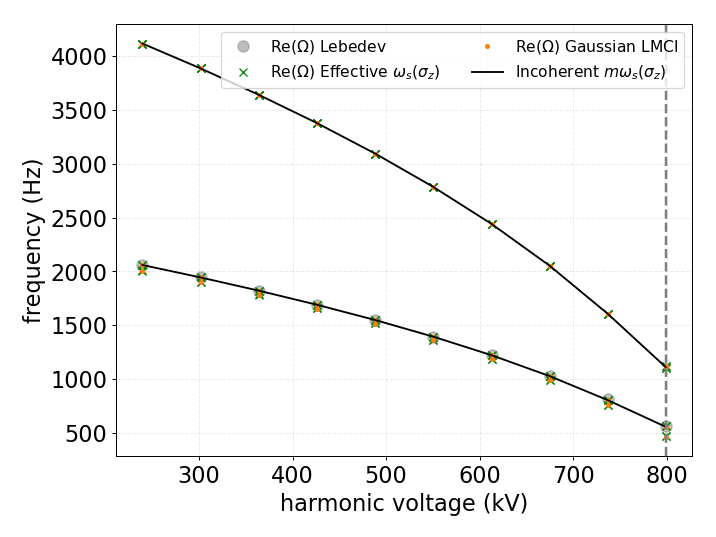

In [78]:
limd = voltages.min()/1e3
limu = voltages.max()/1e3
limu = 810
stepx = 50
xticks = np.arange(350, 800 + stepx, stepx)
stepy = 500
yticks = np.arange(0, 4000 + stepy, stepy)

plot_scan_hc_voltage(
    voltages, fp_voltage,
    ad_rates, cf_rates, mc_rates, ich_freq,
#     xlim=[0, 900],
#     ylim=[0, 4000],
    xticks=None,
    yticks=None, filename=None)

<IPython.core.display.Javascript object>


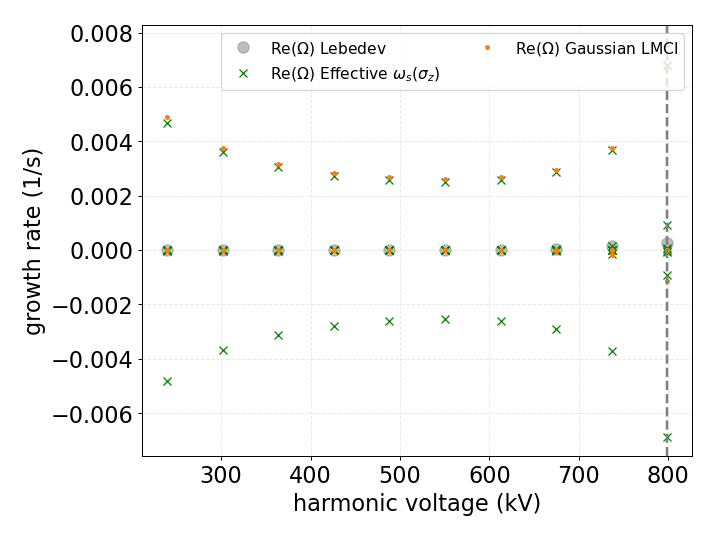

In [79]:
plot_scan_hc_voltage_growth(
    voltages, fp_voltage,
    ad_rates, cf_rates, mc_rates, ich_freq,
#     xlim=[0, 900],
#     ylim=[0, 4000],
    xticks=None,
    yticks=None, filename=None)

In [80]:
thre_lebe = []
thre_effe = []
thre_lmci = []

voltages = np.linspace(2000, 3000, 6) * 1e3

curr0_lebe = 550
curr0_effe = 550
curr0_lmci = 550

# curr0_lebe = 150
# curr0_effe = 150
# curr0_lmci = 150

nr_pts = 20
mmax = 2
curr_max = 800
cbmode = 1

for volt in voltages:
    print(f"RF Voltage {volt/1e3:.2f} kV \n")
    ring.gap_voltage = volt
    
    currents = np.linspace(curr0_lmci, curr_max, nr_pts) * 1e-3   
    print("Gaussian LMCI")
    print("="*20)
    rates_lmci, ich_freq_lmci, threshold_lmci = scan_current_keep_fp(
        currents, ring, [hcav, ], cbmode=cbmode, mmax=mmax, method='lmci')
    thre_lmci.append(threshold_lmci)
    print("\n")
    if threshold_lmci is not None:
        curr0_lmci = threshold_lmci * 1e3
#         curr0_lmci = threshold_lmci * 1e3* 0.9
    
    curr0_lebe = curr0_lmci * 1.025
#     curr0_lebe = curr0_lmci * 0.98
    currents = np.linspace(curr0_lebe, curr_max, nr_pts) * 1e-3    
    print("Lebedev")
    print("="*20)
    rates_lebedev, ich_freq_lebedev, threshold_lebedev = scan_current_keep_fp(
        currents, ring, [hcav, ], cbmode=cbmode, mmax=mmax, method='lebedev')
    thre_lebe.append(threshold_lebedev)
    print("\n")
    if threshold_lebedev is not None:
        curr0_lebe = threshold_lebedev * 1e3
#         curr0_lebe = threshold_lebedev * 1e3 * 0.9
#         curr_max = threshold_lebedev * 1e3 * 1.3
    
    curr0_effe = curr0_lebe * 0.99
#     curr0_effe = curr0_lmci * 0.98
    currents = np.linspace(curr0_effe, curr_max, nr_pts) * 1e-3   
    print("Effective Frequency")
    print("="*20)
    rates_eff, ich_freq_eff, threshold_eff = scan_current_keep_fp(
        currents, ring, [hcav, ], cbmode=cbmode, mmax=mmax, method='effective')
    thre_effe.append(threshold_eff)
    print("\n")
    if threshold_eff is not None:
        curr0_eff = threshold_eff * 1e3 
#         curr0_eff = threshold_eff * 1e3 * 0.9
    
thre_lebe = np.array(thre_lebe)
thre_effe = np.array(thre_effe)
thre_lmci = np.array(thre_lmci)

RF Voltage 2000.00 kV 

Gaussian LMCI
HC voltage (kV)  HC detune (kHz)
Current: 550.00 mA
Growth rate 0.0981, Damping rate 77.52
Current: 563.16 mA
Growth rate 233.1034, Damping rate 77.52


Lebedev
HC voltage (kV)  HC detune (kHz)
Current: 577.24 mA
Growth rate 0.1318, Damping rate 77.52
Current: 588.96 mA
Growth rate 415.3485, Damping rate 77.52


Effective Frequency
HC voltage (kV)  HC detune (kHz)
Current: 583.07 mA
Growth rate 0.4658, Damping rate 77.52
Current: 594.49 mA
Growth rate 616.9003, Damping rate 77.52


RF Voltage 2200.00 kV 

Gaussian LMCI
HC voltage (kV)  HC detune (kHz)
Current: 563.16 mA
Growth rate 0.0512, Damping rate 77.52
Current: 575.62 mA
Growth rate 0.0637, Damping rate 77.52
Current: 588.09 mA
Growth rate 0.0879, Damping rate 77.52
Current: 600.55 mA
Growth rate 0.1923, Damping rate 77.52
Current: 613.02 mA
Growth rate 562.5712, Damping rate 77.52


Lebedev
HC voltage (kV)  HC detune (kHz)
Current: 628.34 mA
Growth rate 155.2430, Damping rate 77.52


Effecti

<IPython.core.display.Javascript object>


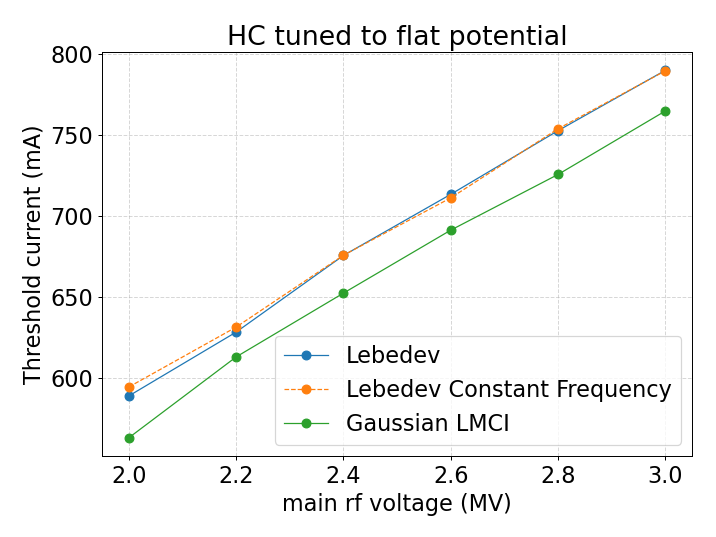

In [81]:
plt.figure(figsize=(8, 6))

plt.plot(voltages/1e6, thre_lebe*1e3, '-o', lw=1, ms=7, label=r'Lebedev')
plt.plot(voltages/1e6, thre_effe*1e3, '--o', lw=1, ms=7, label=r'Lebedev Constant Frequency')
plt.plot(voltages/1e6, thre_lmci*1e3, '-o', lw=1, ms=7, label=r'Gaussian LMCI')
plt.legend()

plt.xlabel("main rf voltage (MV)")
plt.ylabel("Threshold current (mA)")
plt.title("HC tuned to flat potential")
plt.tight_layout()
plt.show()